# **1. Spark Installation**

In [1]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.4.5/spark-2.4.5-bin-hadoop2.7.tgz
!tar xf spark-2.4.5-bin-hadoop2.7.tgz
!pip install -q findspark
!pip install -U pyarrow
!pip install pyspark

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Hit:2 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:3 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:4 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic InRelease [21.3 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Get:9 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran35/ InRelease [3,626 B]
Get:10 http://ppa.launchpad.net/marutter/c2d4u3.5/ubuntu bionic InRelease [15.4 kB]
Get:11 http://archive.ubuntu.com/ubuntu bionic-backports InRelease [74.6 kB]
Get:14 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic/main a

In [2]:
!ls /usr/lib/jvm/

default-java		   java-11-openjdk-amd64     java-8-openjdk-amd64
java-1.11.0-openjdk-amd64  java-1.8.0-openjdk-amd64


In [3]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.5-bin-hadoop2.7"

In [4]:
import findspark
findspark.init()

import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import row_number
from pyspark.sql.functions import col, struct
from time import time
from pyspark.sql.window import Window
import pyspark.sql.functions as F
spark = SparkSession.builder.master("local[*]").getOrCreate()
spark.conf.set("spark.executor.memory", "4g")
spark.conf.set("spark.driver.memory", "4g")
spark.conf.set("spark.memory.fraction", "0.9")

In [5]:
import sys, tempfile, urllib
import urllib.request
from pyspark.sql.functions import*

# **2. Import Libraries**

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline
import plotly.express as px
import plotly.graph_objects as go
import folium
from folium import  plugins
from fbprophet import Prophet

# default plot size
plt.rcParams['figure.figsize'] = 10,12

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# **3. Load Data**

In [7]:
from google.colab import files     
uploaded = files.upload()
corona_dataFrame = spark.read.option("inferSchema", "true").csv("covid_19_data.csv", header = True)

                    

Saving covid_19_data.csv to covid_19_data.csv


# **4. Data preparation**



In [8]:
# drop the null data
t=time()
nullFreeData = corona_dataFrame.na.drop()
nullFreeData.show()
print("The processing Time is: ", time()- t,"seconds")

+---+---------------+--------------+--------------+---------------+---------+------+---------+
|SNo|ObservationDate|Province/State|Country/Region|    Last Update|Confirmed|Deaths|Recovered|
+---+---------------+--------------+--------------+---------------+---------+------+---------+
|  1|     01/22/2020|         Anhui|Mainland China|1/22/2020 17:00|      1.0|   0.0|      0.0|
|  2|     01/22/2020|       Beijing|Mainland China|1/22/2020 17:00|     14.0|   0.0|      0.0|
|  3|     01/22/2020|     Chongqing|Mainland China|1/22/2020 17:00|      6.0|   0.0|      0.0|
|  4|     01/22/2020|        Fujian|Mainland China|1/22/2020 17:00|      1.0|   0.0|      0.0|
|  5|     01/22/2020|         Gansu|Mainland China|1/22/2020 17:00|      0.0|   0.0|      0.0|
|  6|     01/22/2020|     Guangdong|Mainland China|1/22/2020 17:00|     26.0|   0.0|      0.0|
|  7|     01/22/2020|       Guangxi|Mainland China|1/22/2020 17:00|      2.0|   0.0|      0.0|
|  8|     01/22/2020|       Guizhou|Mainland China

# **5. Resilient Distributed Dataset (RDD) Operation**

**RDD Operations in PySpark**: 

1.  Transformation
2.  Action



**Transformations:** 
    1. map
    2. flatMap
    3. filter
    4. distinct
    5. reduceByKey
    6. mapPartitions
    7. sortBy

**Action:**
    1. collect
    2. collectAsMap
    3. reduce
    4. countByKey/countByValue
    5. take
    6. first




**Showing dataframe**

In [ ]:
t=time()
corona_dataFrame.show()
print("The processing Time is: ", time()- t,"seconds")

+---+---------------+--------------+--------------+---------------+---------+------+---------+
|SNo|ObservationDate|Province/State|Country/Region|    Last Update|Confirmed|Deaths|Recovered|
+---+---------------+--------------+--------------+---------------+---------+------+---------+
|  1|     01/22/2020|         Anhui|Mainland China|1/22/2020 17:00|      1.0|   0.0|      0.0|
|  2|     01/22/2020|       Beijing|Mainland China|1/22/2020 17:00|     14.0|   0.0|      0.0|
|  3|     01/22/2020|     Chongqing|Mainland China|1/22/2020 17:00|      6.0|   0.0|      0.0|
|  4|     01/22/2020|        Fujian|Mainland China|1/22/2020 17:00|      1.0|   0.0|      0.0|
|  5|     01/22/2020|         Gansu|Mainland China|1/22/2020 17:00|      0.0|   0.0|      0.0|
|  6|     01/22/2020|     Guangdong|Mainland China|1/22/2020 17:00|     26.0|   0.0|      0.0|
|  7|     01/22/2020|       Guangxi|Mainland China|1/22/2020 17:00|      2.0|   0.0|      0.0|
|  8|     01/22/2020|       Guizhou|Mainland China

**Describle function:**
This function describe the dataframe so when we describe the dataframe basically it's going to gibe the statistics of that particular all the columns that are available. So it's going to give you a summary statistics of it.
For example, it will show you the count value, max and min value, mean and so on.

In [ ]:
# describing
t=time()
corona_dataFrame.describe().show()
print("The processing Time is: ", time()- t,"seconds")

+-------+------------------+---------------+--------------+--------------------+---------------+------------------+-----------------+-----------------+
|summary|               SNo|ObservationDate|Province/State|      Country/Region|    Last Update|         Confirmed|           Deaths|        Recovered|
+-------+------------------+---------------+--------------+--------------------+---------------+------------------+-----------------+-----------------+
|  count|             85638|          85638|         57341|               85638|          85638|             85638|            85638|            85638|
|   mean|           42819.5|           null|          null|                null|           null|13165.188572829818|635.8613232443541|6705.794226861907|
| stddev|24721.705513576526|           null|          null|                null|           null| 39826.02482540336|2624.868348400354|37893.11709194367|
|    min|                 1|     01/22/2020|  Montreal, QC|          Azerbaijan|1/22/202

**Selecting** column

In [ ]:
t=time()
corona_dataFrame.select("Country/Region","Confirmed","Deaths","Recovered").show()
print("The processing Time is: ", time()- t,"seconds")

+--------------+---------+------+---------+
|Country/Region|Confirmed|Deaths|Recovered|
+--------------+---------+------+---------+
|Mainland China|      1.0|   0.0|      0.0|
|Mainland China|     14.0|   0.0|      0.0|
|Mainland China|      6.0|   0.0|      0.0|
|Mainland China|      1.0|   0.0|      0.0|
|Mainland China|      0.0|   0.0|      0.0|
|Mainland China|     26.0|   0.0|      0.0|
|Mainland China|      2.0|   0.0|      0.0|
|Mainland China|      1.0|   0.0|      0.0|
|Mainland China|      4.0|   0.0|      0.0|
|Mainland China|      1.0|   0.0|      0.0|
|Mainland China|      0.0|   0.0|      0.0|
|Mainland China|      5.0|   0.0|      0.0|
|     Hong Kong|      0.0|   0.0|      0.0|
|Mainland China|    444.0|  17.0|     28.0|
|Mainland China|      4.0|   0.0|      0.0|
|Mainland China|      0.0|   0.0|      0.0|
|Mainland China|      1.0|   0.0|      0.0|
|Mainland China|      2.0|   0.0|      0.0|
|Mainland China|      0.0|   0.0|      0.0|
|Mainland China|      2.0|   0.0

**printSchema function** used for showing each of the column and what are the data types.

For example,
serial number: integer
country or region: string
deaths: double

In [ ]:
t=time()
corona_dataFrame.printSchema()
print("The processing Time is: ", time()- t,"seconds")

root
 |-- SNo: integer (nullable = true)
 |-- ObservationDate: string (nullable = true)
 |-- Province/State: string (nullable = true)
 |-- Country/Region: string (nullable = true)
 |-- Last Update: string (nullable = true)
 |-- Confirmed: double (nullable = true)
 |-- Deaths: double (nullable = true)
 |-- Recovered: double (nullable = true)

The processing Time is:  0.009432077407836914 seconds


**Count function:** Returns the number of rows in this DataFrame

In [ ]:
t=time()
corona_dataFrame.count()
print("The processing Time is: ", time()- t,"seconds")

The processing Time is:  0.26320981979370117 seconds


I use **explain()** function to show the actual execution plan in spark engine will creates and uses while executing query.

In [ ]:
t=time()
corona_dataFrame.explain()
print("The processing Time is: ", time()- t,"seconds")

== Physical Plan ==
*(1) FileScan csv [SNo#606,ObservationDate#607,Province/State#608,Country/Region#609,Last Update#610,Confirmed#611,Deaths#612,Recovered#613] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/content/covid_19_data.csv], PartitionFilters: [], PushedFilters: [], ReadSchema: struct<SNo:int,ObservationDate:string,Province/State:string,Country/Region:string,Last Update:str...
The processing Time is:  0.013428688049316406 seconds


**first()** function use for show print the first row of the database

In [ ]:
t=time()
corona_dataFrame.first()
print("The processing Time is: ", time()- t,"seconds")

The processing Time is:  0.08992362022399902 seconds


In [ ]:
# take first 10 rows
t=time()
corona_dataFrame.take(10)
#print("The processing Time is: ", time()- t,"seconds")

[Row(SNo=1, ObservationDate='01/22/2020', Province/State='Anhui', Country/Region='Mainland China', Last Update='1/22/2020 17:00', Confirmed=1.0, Deaths=0.0, Recovered=0.0),
 Row(SNo=2, ObservationDate='01/22/2020', Province/State='Beijing', Country/Region='Mainland China', Last Update='1/22/2020 17:00', Confirmed=14.0, Deaths=0.0, Recovered=0.0),
 Row(SNo=3, ObservationDate='01/22/2020', Province/State='Chongqing', Country/Region='Mainland China', Last Update='1/22/2020 17:00', Confirmed=6.0, Deaths=0.0, Recovered=0.0),
 Row(SNo=4, ObservationDate='01/22/2020', Province/State='Fujian', Country/Region='Mainland China', Last Update='1/22/2020 17:00', Confirmed=1.0, Deaths=0.0, Recovered=0.0),
 Row(SNo=5, ObservationDate='01/22/2020', Province/State='Gansu', Country/Region='Mainland China', Last Update='1/22/2020 17:00', Confirmed=0.0, Deaths=0.0, Recovered=0.0),
 Row(SNo=6, ObservationDate='01/22/2020', Province/State='Guangdong', Country/Region='Mainland China', Last Update='1/22/2020 1

**Filtering** data by country wise


In [ ]:
from pyspark.sql.functions import col
t=time() 
corona_dataFrame.filter(col("Country/Region")==("Luxembourg")).show()
print("The processing Time is: ", time()- t,"seconds")

+----+---------------+--------------+--------------+-------------------+---------+------+---------+
| SNo|ObservationDate|Province/State|Country/Region|        Last Update|Confirmed|Deaths|Recovered|
+----+---------------+--------------+--------------+-------------------+---------+------+---------+
|2796|     02/29/2020|          null|    Luxembourg|2020-02-29T21:03:05|      1.0|   0.0|      0.0|
|2922|     03/01/2020|          null|    Luxembourg|2020-03-01T07:13:07|      1.0|   0.0|      0.0|
|3055|     03/02/2020|          null|    Luxembourg|2020-03-01T07:13:07|      1.0|   0.0|      0.0|
|3204|     03/03/2020|          null|    Luxembourg|2020-03-03T00:23:16|      1.0|   0.0|      0.0|
|3366|     03/04/2020|          null|    Luxembourg|2020-03-03T00:23:16|      1.0|   0.0|      0.0|
|3535|     03/05/2020|          null|    Luxembourg|2020-03-03T00:23:16|      1.0|   0.0|      0.0|
|3690|     03/06/2020|          null|    Luxembourg|2020-03-06T01:29:39|      2.0|   0.0|      0.0|


Filtering the dataFarame where the confirmed case **grater than 100000** and sort with with confirmed column

In [ ]:
t=time()
corona_dataFrame.filter("Confirmed>100000").sort(col("Confirmed")).show()
print("The processing Time is: ", time()- t,"seconds")


+-----+---------------+--------------+--------------+-------------------+---------+------+---------+
|  SNo|ObservationDate|Province/State|Country/Region|        Last Update|Confirmed|Deaths|Recovered|
+-----+---------------+--------------+--------------+-------------------+---------+------+---------+
|17950|     04/23/2020|    New Jersey|            US|2020-04-24 03:31:35| 100025.0|5426.0|      0.0|
|83381|     08/09/2020|      Virginia|            US|2020-08-10 04:34:55| 100086.0|2326.0|      0.0|
|11990|     04/05/2020|          null|       Germany|2020-04-05 23:13:44| 100123.0|1584.0|  28700.0|
|75420|     07/30/2020|      Amazonas|        Brazil|2020-07-31 04:35:18| 100140.0|3252.0|  84218.0|
|83491|     08/10/2020|          null|    Kazakhstan|2020-08-11 04:35:08| 100164.0|1058.0|  73702.0|
|61953|     07/12/2020|          null|     Argentina|2020-07-13 04:43:04| 100166.0|1845.0|  42694.0|
|82100|     08/08/2020|       Alabama|            US|2020-08-09 04:34:54| 100173.0|1755.0| 

Sort by **Ascending** **descending** (ASC & DSC)

In [ ]:
#sort Country/Region column with ascending and Last update with descending order
t=time()
corona_dataFrame.sort(col("Country/Region").asc(), col("Last Update").desc()).show(truncate=False)
print("The processing Time is: ", time()- t,"seconds")


+-----+---------------+--------------+---------------+-------------------+---------+------+---------+
|SNo  |ObservationDate|Province/State|Country/Region |Last Update        |Confirmed|Deaths|Recovered|
+-----+---------------+--------------+---------------+-------------------+---------+------+---------+
|2664 |02/28/2020     |null          | Azerbaijan    |2020-02-28T15:03:26|1.0      |0.0   |0.0      |
|4675 |03/10/2020     |null          |('St. Martin',)|2020-03-10T05:33:02|2.0      |0.0   |0.0      |
|12248|04/06/2020     |null          |Afghanistan    |4/6/20 9:37        |367.0    |11.0  |18.0     |
|11613|04/04/2020     |null          |Afghanistan    |4/4/20 9:38        |299.0    |7.0   |10.0     |
|10983|04/02/2020     |null          |Afghanistan    |4/2/20 8:53        |273.0    |6.0   |10.0     |
|10045|03/30/2020     |null          |Afghanistan    |3/8/20 5:31        |170.0    |4.0   |2.0      |
|9423 |03/28/2020     |null          |Afghanistan    |3/8/20 5:31        |110.0   

Finding **Maximum & minimum** deaths, confirmed and recovered

In [ ]:
t=time()
corona_dataFrame.groupby('Country/Region').agg({'Confirmed': 'max'}).show()
corona_dataFrame.groupby('Country/Region').agg({'Deaths': 'max'}).show()
corona_dataFrame.groupby('Country/Region').agg({'Recovered': 'max'}).show()
corona_dataFrame.groupBy("Country/Region","Province/State").agg(F.max("ObservationDate")).show()
print("The processing Time is: ", time()- t,"seconds")

+--------------+--------------+
|Country/Region|max(Confirmed)|
+--------------+--------------+
|          Chad|         949.0|
|        Russia|      405843.0|
|      Paraguay|        8018.0|
| North Ireland|           1.0|
|         Yemen|        1841.0|
|       Senegal|       11587.0|
|        Sweden|       41883.0|
|    Cabo Verde|        3000.0|
|        Guyana|         623.0|
|   Philippines|      143749.0|
|        Jersey|           2.0|
|       Eritrea|         285.0|
|         Burma|         361.0|
|      Djibouti|        5358.0|
|     Singapore|       55395.0|
|      Malaysia|        9114.0|
|          Fiji|          27.0|
|        Turkey|      244392.0|
|        Malawi|        4752.0|
|Western Sahara|          10.0|
+--------------+--------------+
only showing top 20 rows

+--------------+-----------+
|Country/Region|max(Deaths)|
+--------------+-----------+
|          Chad|       76.0|
|        Russia|     4693.0|
|      Paraguay|       93.0|
| North Ireland|        0.0|
|  

Joining another column using join, agg, alias methods

In [ ]:
t=time()
maximum_data = corona_dataFrame.join(corona_dataFrame.groupBy("Country/Region","Province/State").agg(F.max("Confirmed").alias("Confirmed")),on=["Country/Region", "Province/State","Confirmed"],how="Leftouter")
maximum_data.show(100)
print("The processing Time is: ", time()- t,"seconds")

+--------------+--------------+---------+---+---------------+---------------+------+---------+
|Country/Region|Province/State|Confirmed|SNo|ObservationDate|    Last Update|Deaths|Recovered|
+--------------+--------------+---------+---+---------------+---------------+------+---------+
|Mainland China|         Anhui|      1.0|  1|     01/22/2020|1/22/2020 17:00|   0.0|      0.0|
|Mainland China|       Beijing|     14.0|  2|     01/22/2020|1/22/2020 17:00|   0.0|      0.0|
|Mainland China|     Chongqing|      6.0|  3|     01/22/2020|1/22/2020 17:00|   0.0|      0.0|
|Mainland China|        Fujian|      1.0|  4|     01/22/2020|1/22/2020 17:00|   0.0|      0.0|
|Mainland China|         Gansu|      0.0|  5|     01/22/2020|1/22/2020 17:00|   0.0|      0.0|
|Mainland China|     Guangdong|     26.0|  6|     01/22/2020|1/22/2020 17:00|   0.0|      0.0|
|Mainland China|       Guangxi|      2.0|  7|     01/22/2020|1/22/2020 17:00|   0.0|      0.0|
|Mainland China|       Guizhou|      1.0|  8|     

In [ ]:
t=time()
corona_dataFrame.join(corona_dataFrame.groupBy("Country/Region","Province/State").agg(F.max("ObservationDate").alias("ObservationDate")),on=["Country/Region", "Province/State","ObservationDate"],how="inner").show()
print("The processing Time is: ", time()- t,"seconds")

+--------------+--------------------+---------------+----+-------------------+---------+------+---------+
|Country/Region|      Province/State|ObservationDate| SNo|        Last Update|Confirmed|Deaths|Recovered|
+--------------+--------------------+---------------+----+-------------------+---------+------+---------+
|            US|             Chicago|     01/24/2020| 119|      1/24/20 17:00|      1.0|   0.0|      0.0|
|       Germany|             Bavaria|     01/31/2020| 472|    1/31/2020 23:59|      5.0|   0.0|      0.0|
|        Others|         Cruise Ship|     02/08/2020|1006|2020-02-07T16:33:03|     61.0|   0.0|      0.0|
|            US|         Ashland, NE|     02/21/2020|1986|2020-02-21T23:23:06|     11.0|   0.0|      0.0|
|            US|          Travis, CA|     02/21/2020|1992|2020-02-21T23:23:06|      5.0|   0.0|      0.0|
|            US|        Lackland, TX|     02/21/2020|2003|2020-02-21T23:23:06|      2.0|   0.0|      0.0|
|       Lebanon|                None|     02/2

Showing most 10 countries confirmed cases

In [ ]:
t=time()
corona_dataFrame.join(corona_dataFrame.groupBy("Country/Region","Province/State").agg(F.max("Confirmed").alias("Confirmed")),on=["Country/Region", "Province/State","Confirmed"],how="inner").sort("Confirmed",ascending=False).show(10)
print("The processing Time is: ", time()- t,"seconds")

+--------------+--------------+---------+-----+---------------+-------------------+-------+---------+
|Country/Region|Province/State|Confirmed|  SNo|ObservationDate|        Last Update| Deaths|Recovered|
+--------------+--------------+---------+-----+---------------+-------------------+-------+---------+
|        Brazil|     Sao Paulo| 655181.0|85509|     08/12/2020|2020-08-13 04:29:15|25869.0| 453612.0|
|            US|    California| 591376.0|85140|     08/12/2020|2020-08-13 04:29:15|10753.0|      0.0|
|            US|       Florida| 550901.0|85204|     08/12/2020|2020-08-13 04:29:15| 8765.0|      0.0|
|         India|   Maharashtra| 548313.0|85348|     08/12/2020|2020-08-13 04:29:15|18650.0| 381843.0|
|            US|         Texas| 523977.0|85554|     08/12/2020|2020-08-13 04:29:15| 9527.0|      0.0|
|            US|      New York| 422703.0|85405|     08/12/2020|2020-08-13 04:29:15|32797.0|      0.0|
|         India|    Tamil Nadu| 314520.0|85547|     08/12/2020|2020-08-13 04:29:15

Aggregation function or agg() function which helps to show the max or min valule in row for every column with the help of collect() funciton

In [ ]:
t=time()
corona_dataFrame.agg({"Last Update":"max", "Confirmed":"max","Deaths":"max","Recovered":"max"}).collect()
print("The processing Time is: ", time()- t,"seconds")

The processing Time is:  0.3839125633239746 seconds


Showing max value in column

In [ ]:
t=time()
max_recovered = corona_dataFrame.agg({"Recovered":"max"})
max_Confirmed = corona_dataFrame.agg({"Confirmed":"max"})
max_Deaths= corona_dataFrame.agg({"Deaths":"max"})
print("The processing Time is: ", time()- t,"seconds")


The processing Time is:  0.020050525665283203 seconds


In [ ]:
t=time()
max_Confirmed.show()
max_recovered.show()
max_Deaths.show()
print("The processing Time is: ", time()- t,"seconds")

+--------------+
|max(Confirmed)|
+--------------+
|      655181.0|
+--------------+

+--------------+
|max(Recovered)|
+--------------+
|     1753760.0|
+--------------+

+-----------+
|max(Deaths)|
+-----------+
|    42072.0|
+-----------+

The processing Time is:  0.9158692359924316 seconds


Quantile: 

In [ ]:
t=time()
corona_dataFrame.filter("Confirmed>10000").approxQuantile("Confirmed",[0.25,0.50,0.75,0.8,0.90,0.95],0.90)
print("The processing Time is: ", time()- t,"seconds")

The processing Time is:  0.33688974380493164 seconds


In [ ]:
t=time()
corona_dataFrame.filter("Deaths>1000").approxQuantile("Deaths",[0.25,0.50,0.75,0.90,0.95],0.90)
#print("The processing Time is: ", time()- t,"seconds")

[1001.0, 1001.0, 1001.0, 1001.0, 42072.0]

In [ ]:
t=time()
corona_dataFrame.filter("Recovered>1000").approxQuantile("Recovered",[0.25,0.50,0.75,0.90,0.95],0.90)
#print("The processing Time is: ", time()- t,"seconds")

[1001.0, 1001.0, 1001.0, 1001.0, 1753760.0]

Partition by Country/Region and Province/State
**Window function:**Window functions allow users of Spark SQL to calculate results such as the rank of a given row or a moving average over a range of input rows. They significantly improve the expressiveness of Spark’s SQL and DataFrame APIs.


In [ ]:
t=time()
window_specification=Window().partitionBy("Country/Region","Province/State").orderBy(col("ObservationDate").desc())
corona_dataFrame.withColumn("row_No",row_number().over(window_specification)).show()
print("The processing Time is: ", time()- t,"seconds")

+-----+---------------+--------------+--------------+-------------------+---------+-------+---------+------+
|  SNo|ObservationDate|Province/State|Country/Region|        Last Update|Confirmed| Deaths|Recovered|row_No|
+-----+---------------+--------------+--------------+-------------------+---------+-------+---------+------+
|85348|     08/12/2020|   Maharashtra|         India|2020-08-13 04:29:15| 548313.0|18650.0| 381843.0|     1|
|84606|     08/11/2020|   Maharashtra|         India|2020-08-12 04:27:29| 535601.0|18306.0| 368435.0|     2|
|83863|     08/10/2020|   Maharashtra|         India|2020-08-11 04:35:08| 524513.0|18050.0| 358421.0|     3|
|83120|     08/09/2020|   Maharashtra|         India|2020-08-10 04:34:55| 515332.0|17757.0| 351710.0|     4|
|82377|     08/08/2020|   Maharashtra|         India|2020-08-09 04:34:54| 503084.0|17367.0| 338362.0|     5|
|81634|     08/07/2020|   Maharashtra|         India|2020-08-08 04:34:53| 490262.0|17092.0| 327281.0|     6|
|80891|     08/06/2

showing for each country only the first row number 

In [ ]:
t=time()
corona_dataFrame.withColumn("row_No", row_number().over(window_specification)).where(col("row_No")==1).show()
print("The processing Time is: ", time()- t,"seconds")

+-----+---------------+--------------------+--------------+-------------------+---------+-------+---------+------+
|  SNo|ObservationDate|      Province/State|Country/Region|        Last Update|Confirmed| Deaths|Recovered|row_No|
+-----+---------------+--------------------+--------------+-------------------+---------+-------+---------+------+
|85348|     08/12/2020|         Maharashtra|         India|2020-08-13 04:29:15| 548313.0|18650.0| 381843.0|     1|
|85411|     08/12/2020|       Noord-Brabant|   Netherlands|2020-08-13 04:29:15|  10873.0| 1542.0|      0.0|     1|
| 4396|     03/09/2020|  Douglas County, CO|            US|2020-03-07T01:53:03|      3.0|    0.0|      0.0|     1|
|84928|     08/12/2020|                null|          Chad|2020-08-13 04:29:15|    949.0|   76.0|    859.0|     1|
|85183|     08/12/2020|Dadra and Nagar H...|         India|2020-08-13 04:29:15|   1696.0|    2.0|   1248.0|     1|
|85221|     08/12/2020|                 Goa|         India|2020-08-13 04:29:15| 

Convert the observationDate rows into column for showing the each and every date for every country

In [ ]:
t=time()
corona_dataFrame.groupby("Country/Region").pivot("ObservationDate").agg(F.sum("Confirmed")).show()
print("The processing Time is: ", time()- t,"seconds")

+--------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+-----

Creating **Catagorical** value with 1 or 0 filtering by Country

In [ ]:
t=time()
corona_dataFrame.filter(col("Country/Region")=="US").crosstab("Province/State", "ObservationDate").show()
print("The processing Time is: ", time()- t,"seconds")

+------------------------------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+----------+

maximum sum of confirmed cases in every country

In [ ]:
t=time()
corona_dataFrame.groupBy("Country/Region").agg({'Confirmed':'sum'}).show()
print("The processing Time is: ", time()- t,"seconds")


+--------------+--------------+
|Country/Region|sum(Confirmed)|
+--------------+--------------+
|          Chad|       79244.0|
|        Russia|   5.9201023E7|
|      Paraguay|      254489.0|
| North Ireland|           1.0|
|         Yemen|       95438.0|
|       Senegal|      637604.0|
|        Sweden|     6268635.0|
|    Cabo Verde|      125268.0|
|        Guyana|       27071.0|
|   Philippines|     4779755.0|
|        Jersey|           6.0|
|       Eritrea|       16270.0|
|         Burma|       30886.0|
|      Djibouti|      419996.0|
|     Singapore|     4360627.0|
|      Malaysia|     1021288.0|
|          Fiji|        2698.0|
|        Turkey|   2.1676347E7|
|        Malawi|      159013.0|
|Western Sahara|        1061.0|
+--------------+--------------+
only showing top 20 rows

The processing Time is:  0.5830464363098145 seconds


Now sum Confirmed Recovered and Death ordered by Confirmed

In [ ]:
t=time()
corona_dataFrame.groupBy("Country/Region").agg({'Confirmed':'sum', 'Recovered':'sum', 'Deaths':'sum'}).orderBy("sum(Confirmed)", ascending = False).show()
print("The processing Time is: ", time()- t,"seconds")

+--------------+--------------+-----------+--------------+
|Country/Region|sum(Recovered)|sum(Deaths)|sum(Confirmed)|
+--------------+--------------+-----------+--------------+
|            US|   8.1162917E7|1.3399185E7|  3.00808412E8|
|        Brazil|   8.9458824E7|  5484448.0|   1.3490728E8|
|         India|   4.4797115E7|  1756241.0|     7.19961E7|
|        Russia|   3.5735389E7|   849662.0|   5.9201023E7|
|         Spain|   1.7584578E7|  3488885.0|   3.2379576E7|
|            UK|      149484.0|  4671749.0|   3.2326419E7|
|         Italy|   1.8889311E7|  4270305.0|    3.072521E7|
|          Peru|   1.5734356E7|   972619.0|   2.6334216E7|
|        France|     8510250.0|  3533119.0|   2.5149684E7|
|       Germany|   2.0220707E7|  1018086.0|   2.4480948E7|
|          Iran|   1.9582711E7|  1306160.0|   2.4388496E7|
|        Mexico|   1.6854272E7|  2520489.0|    2.217576E7|
|         Chile|   1.8473612E7|   478499.0|   2.1983524E7|
|        Turkey|   1.6851834E7|   558365.0|   2.1676347E

Adding new column active case in my DataFrame

In [ ]:
t=time()
corona_dataFrame.withColumn("Active_case", corona_dataFrame.Confirmed - corona_dataFrame.Recovered - corona_dataFrame.Deaths).sort("Active_case", ascending = False).show()
print("The processing Time is: ", time()- t,"seconds")

+-----+---------------+--------------+--------------+-------------------+---------+-------+---------+-----------+
|  SNo|ObservationDate|Province/State|Country/Region|        Last Update|Confirmed| Deaths|Recovered|Active_case|
+-----+---------------+--------------+--------------+-------------------+---------+-------+---------+-----------+
|85140|     08/12/2020|    California|            US|2020-08-13 04:29:15| 591376.0|10753.0|      0.0|   580623.0|
|84398|     08/11/2020|    California|            US|2020-08-12 04:27:29| 578946.0|10523.0|      0.0|   568423.0|
|83655|     08/10/2020|    California|            US|2020-08-11 04:35:08| 574231.0|10476.0|      0.0|   563755.0|
|82912|     08/09/2020|    California|            US|2020-08-10 04:34:55| 559746.0|10377.0|      0.0|   549369.0|
|82169|     08/08/2020|    California|            US|2020-08-09 04:34:54| 554388.0|10307.0|      0.0|   544081.0|
|85204|     08/12/2020|       Florida|            US|2020-08-13 04:29:15| 550901.0| 8765

Maximum active case in my dataset

In [ ]:
t=time()
maximum_data = maximum_data.withColumn("Active_case", maximum_data.Confirmed - maximum_data.Recovered - maximum_data.Deaths)
maximum_data.show(100)
print("The processing Time is: ", time()- t,"seconds")

+--------------+--------------+---------+---+---------------+---------------+------+---------+-----------+
|Country/Region|Province/State|Confirmed|SNo|ObservationDate|    Last Update|Deaths|Recovered|Active_case|
+--------------+--------------+---------+---+---------------+---------------+------+---------+-----------+
|Mainland China|         Anhui|      1.0|  1|     01/22/2020|1/22/2020 17:00|   0.0|      0.0|        1.0|
|Mainland China|       Beijing|     14.0|  2|     01/22/2020|1/22/2020 17:00|   0.0|      0.0|       14.0|
|Mainland China|     Chongqing|      6.0|  3|     01/22/2020|1/22/2020 17:00|   0.0|      0.0|        6.0|
|Mainland China|        Fujian|      1.0|  4|     01/22/2020|1/22/2020 17:00|   0.0|      0.0|        1.0|
|Mainland China|         Gansu|      0.0|  5|     01/22/2020|1/22/2020 17:00|   0.0|      0.0|        0.0|
|Mainland China|     Guangdong|     26.0|  6|     01/22/2020|1/22/2020 17:00|   0.0|      0.0|       26.0|
|Mainland China|       Guangxi|      

Ordering sum of active cases

In [ ]:
t=time()
sum_of_Active_cases = maximum_data.groupby("Country/Region").sum("Active_case").orderBy("sum(Active_case)", ascending = False)
sum_of_Active_cases.show(10)
print("The processing Time is: ", time()- t,"seconds")

+--------------+----------------+
|Country/Region|sum(Active_case)|
+--------------+----------------+
|            US|     2.0624631E8|
|        Brazil|     3.9964008E7|
|            UK|     2.7505186E7|
|         India|     2.5442744E7|
|        Russia|     2.2615972E7|
|        France|     1.3106315E7|
|         Spain|     1.1306113E7|
|          Peru|       9627241.0|
|         Italy|       7565594.0|
|  South Africa|       7505147.0|
+--------------+----------------+
only showing top 10 rows

The processing Time is:  2.614938497543335 seconds


showing different record for more countries

In [ ]:
t=time()
corona_dataFrame.select("Country/Region", "Province/State", "Confirmed", "Recovered").filter(col("Country/Region").isin("Australia","Bangladesh")).groupBy("Country/Region").sum().show()
print("The processing Time is: ", time()- t,"seconds")

+--------------+--------------+--------------+
|Country/Region|sum(Confirmed)|sum(Recovered)|
+--------------+--------------+--------------+
|    Bangladesh|   1.2707434E7|     5972993.0|
|     Australia|     1269875.0|      883252.0|
+--------------+--------------+--------------+

The processing Time is:  1.1387054920196533 seconds


Getting sub total

In [ ]:
t=time()
corona_dataFrame.select("Country/Region", "Province/State", "Confirmed", "Recovered").filter(col("Country/Region").isin('Luxembourg','Bangladesh','US')).cube("Country/Region").sum().show()
print("The processing Time is: ", time()- t,"seconds")

+--------------+--------------+--------------+
|Country/Region|sum(Confirmed)|sum(Recovered)|
+--------------+--------------+--------------+
|          null|  3.14128174E8|   8.7604597E7|
|    Luxembourg|      612328.0|      468687.0|
|            US|  3.00808412E8|   8.1162917E7|
|    Bangladesh|   1.2707434E7|     5972993.0|
+--------------+--------------+--------------+

The processing Time is:  1.4191083908081055 seconds


show each and every state sum:

In [ ]:
t=time()
corona_dataFrame.select("Country/Region", "Province/State", "Confirmed", "Recovered").filter(col("Country/Region").isin('Canada','US')).cube("Country/Region","Province/State").sum().show()
print("The processing Time is: ", time()- t,"seconds")

+--------------+--------------------+--------------+--------------+
|Country/Region|      Province/State|sum(Confirmed)|sum(Recovered)|
+--------------+--------------------+--------------+--------------+
|        Canada|   Edmonton, Alberta|           4.0|           0.0|
|          null|          Boston, MA|          34.0|           7.0|
|          null|            Maryland|     6863672.0|           6.0|
|            US|      Providence, RI|          11.0|           0.0|
|          null|      Providence, RI|          11.0|           0.0|
|          null| Saratoga County, NY|           6.0|           0.0|
|          null|Santa Cruz County...|           1.0|           0.0|
|            US|St. Louis County, MO|           2.0|           0.0|
|            US|            Kentucky|     1773207.0|           2.0|
|          null|Montgomery County...|           9.0|           0.0|
|          null|    Washington, D.C.|           4.0|           0.0|
|            US|        Lackland, TX|           

In [ ]:
t=time()
corona_dataFrame.select("Country/Region", "Province/State", "Confirmed", "Recovered").filter(col("Country/Region").isin('India','Australia')).rollup("Country/Region","Province/State").sum().show(10)
print("The processing Time is: ", time()- t,"seconds")

+--------------+------------------+--------------+--------------+
|Country/Region|    Province/State|sum(Confirmed)|sum(Recovered)|
+--------------+------------------+--------------+--------------+
|         India|        Puducherry|      121874.0|       69173.0|
|         India|      Chhattisgarh|      339143.0|      241525.0|
|     Australia|              null|           8.0|           0.0|
|     Australia|Northern Territory|        4058.0|        3219.0|
|         India|         Karnataka|     3944580.0|     1788459.0|
|         India|        Tamil Nadu|     9644256.0|     6776741.0|
|         India|             Bihar|     1774524.0|     1172143.0|
|         India|           Manipur|      112667.0|       63290.0|
|         India|       Uttarakhand|      292243.0|      191579.0|
|          null|              null|   7.3265975E7|   4.5680367E7|
+--------------+------------------+--------------+--------------+
only showing top 10 rows

The processing Time is:  0.977046012878418 seconds

correlation between two column

In [ ]:
t=time()
maximum_data.corr("Confirmed","Recovered")
print("The processing Time is: ", time()- t,"seconds")

The processing Time is:  1.4808101654052734 seconds


# **6. covert Spark data into pandas**

In [ ]:
t=time()
pandas_corona_dataFrame = corona_dataFrame.toPandas()
pandas_corona_dataFrame.head()
#print("The processing Time is: ", time()- t,"seconds")

,SNo,ObservationDate,Province/State,Country/Region,Last Update,Confirmed,Deaths,Recovered
0,1,01/22/2020,Anhui,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
1,2,01/22/2020,Beijing,Mainland China,1/22/2020 17:00,14.0,0.0,0.0
2,3,01/22/2020,Chongqing,Mainland China,1/22/2020 17:00,6.0,0.0,0.0
3,4,01/22/2020,Fujian,Mainland China,1/22/2020 17:00,1.0,0.0,0.0
4,5,01/22/2020,Gansu,Mainland China,1/22/2020 17:00,0.0,0.0,0.0


correlation matrics

In [ ]:
t=time()
pandas_corona_dataFrame.corr()
print("The processing Time is: ", time()- t,"seconds")

The processing Time is:  0.010704517364501953 seconds


In [ ]:
t=time()
pandas_corona_dataFrame.isnull().sum()
#print("The processing Time is: ", time()- t,"seconds")

SNo                    0
ObservationDate        0
Province/State     28297
Country/Region         0
Last Update            0
Confirmed              0
Deaths                 0
Recovered              0
dtype: int64

# **7. Data Visualizing**

In [ ]:
t=time()
confirmed_case = pandas_corona_dataFrame.groupby('ObservationDate').sum()['Confirmed'].reset_index()
deaths_case = pandas_corona_dataFrame.groupby('ObservationDate').sum()['Deaths'].reset_index()
recovered_case = pandas_corona_dataFrame.groupby('ObservationDate').sum()['Recovered'].reset_index()
print("The processing Time is: ", time()- t,"seconds")

The processing Time is:  0.07306599617004395 seconds


In [ ]:
#Plotting datewise confirmed, deaths, recovered cases
t=time()
fig = go.Figure()
fig.add_trace(go.Scatter(x=confirmed_case['ObservationDate'], y=confirmed_case['Confirmed'], mode='lines+markers', name='Confirmed',line=dict(color='blue', width=2)))
fig.add_trace(go.Scatter(x=deaths_case['ObservationDate'], y=deaths_case['Deaths'], mode='lines+markers', name='Deaths', line=dict(color='Red', width=2)))
fig.add_trace(go.Scatter(x=recovered_case['ObservationDate'], y=recovered_case['Recovered'], mode='lines+markers', name='Recovered', line=dict(color='Green', width=2)))
fig.update_layout(title='Worldwide COVID-19 Cases', xaxis_tickfont_size=14,yaxis=dict(title='Number of Cases'))

fig.show()
print("The processing Time is: ", time()- t,"seconds")

The processing Time is:  0.30569958686828613 seconds


Forecasting **Confirmed COVID-19** Cases Worldwide

In [ ]:
t=time()
confirmed_case.columns = ['ds','y']
confirmed_case['ds'] = pd.to_datetime(confirmed_case['ds'])
print("The processing Time is: ", time()- t,"seconds")

The processing Time is:  0.0031609535217285156 seconds


In [ ]:
t=time()
confirmed_case.tail()
#print("The processing Time is: ", time()- t,"seconds")

,ds,y
199,2020-08-08,19637506.0
200,2020-08-09,19861683.0
201,2020-08-10,20089624.0
202,2020-08-11,20343589.0
203,2020-08-12,20620847.0


In [ ]:
t=time()
model = Prophet(interval_width=0.95)
model.fit(confirmed_case)
future = model.make_future_dataframe(periods=7)
future.tail()
print("The processing Time is: ", time()- t,"seconds")

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


The processing Time is:  1.8357467651367188 seconds


In [ ]:
#predicting the future with date, and upper and lower limit of y value
t=time()
fore_confirm_cases = model.predict(future)
fore_confirm_cases[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
print("The processing Time is: ", time()- t,"seconds")

The processing Time is:  1.9301674365997314 seconds


The processing Time is:  0.08375835418701172 seconds


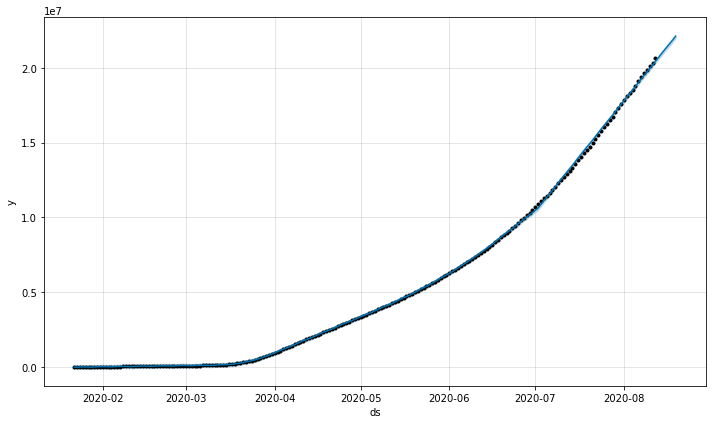

In [ ]:
t=time()
fore_confirmed_plot = model.plot(fore_confirm_cases)
print("The processing Time is: ", time()- t,"seconds")

The processing Time is:  0.12999248504638672 seconds


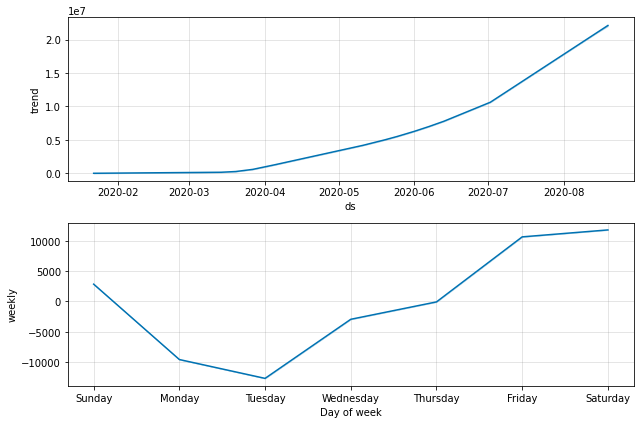

In [ ]:
t=time()
fore_confirmed_plot =model.plot_components(fore_confirm_cases)
print("The processing Time is: ", time()- t,"seconds")

Forecasting **Recovered COVID-19** Cases Worldwide

---



In [ ]:
t=time()
recovered_case.columns = ['ds','y']
recovered_case['ds'] = pd.to_datetime(recovered_case['ds'])
print("The processing Time is: ", time()- t,"seconds")

The processing Time is:  0.0016412734985351562 seconds


In [ ]:
recovered_case.tail(10)

,ds,y
194,2020-08-03,10913000.0
195,2020-08-04,11134735.0
196,2020-08-05,11356275.0
197,2020-08-06,11545401.0
198,2020-08-07,11737927.0
199,2020-08-08,11939109.0
200,2020-08-09,12115825.0
201,2020-08-10,12280520.0
202,2020-08-11,12585473.0
203,2020-08-12,12826815.0


In [ ]:
model = Prophet(interval_width=0.95)
model.fit(recovered_case)
future = model.make_future_dataframe(periods=7)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
206,2020-08-15
207,2020-08-16
208,2020-08-17
209,2020-08-18
210,2020-08-19


In [ ]:
#predicting the future with date, and upper and lower limit of y value
fore_recovered_cases = model.predict(future)
fore_recovered_cases[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
206,2020-08-15,1.295865e+07,1.279899e+07,1.311559e+07
207,2020-08-16,1.311587e+07,1.296646e+07,1.328451e+07
208,2020-08-17,1.328435e+07,1.312893e+07,1.344045e+07
209,2020-08-18,1.345629e+07,1.330448e+07,1.361437e+07
210,2020-08-19,1.363827e+07,1.345245e+07,1.380228e+07


The processing Time is:  0.06696724891662598 seconds


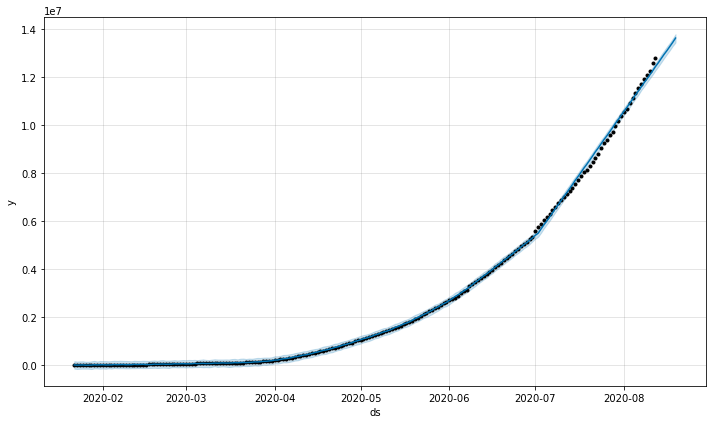

In [ ]:
t=time()
fore_recovered_plot = model.plot(fore_recovered_cases)
print("The processing Time is: ", time()- t,"seconds")

The processing Time is:  0.13489484786987305 seconds


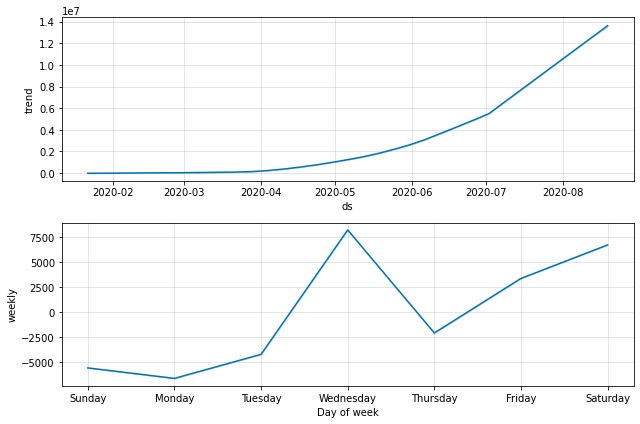

In [ ]:
t=time()
fore_recovered_plot =model.plot_components(fore_recovered_cases)
print("The processing Time is: ", time()- t,"seconds")

Forecasting Recovered COVID-19 Cases Worldwide

In [ ]:
deaths_case.columns = ['ds','y']
deaths_case['ds'] = pd.to_datetime(deaths_case['ds'])

deaths_case.tail()

,ds,y
199,2020-08-08,726781.0
200,2020-08-09,731326.0
201,2020-08-10,736191.0
202,2020-08-11,742615.0
203,2020-08-12,749358.0


In [ ]:
model = Prophet(interval_width=0.95)
model.fit(deaths_case)
future = model.make_future_dataframe(periods=7)
future.tail()

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


,ds
206,2020-08-15
207,2020-08-16
208,2020-08-17
209,2020-08-18
210,2020-08-19


In [ ]:
#predicting the future with date, and upper and lower limit of y value
fore_deaths_cases = model.predict(future)
fore_deaths_cases[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
206,2020-08-15,763379.999191,759877.255006,766671.093901
207,2020-08-16,767972.033822,763866.257940,771685.230872
208,2020-08-17,772721.347088,768142.452836,777105.587277
209,2020-08-18,778744.078594,773888.425761,784469.296444
210,2020-08-19,785069.603514,778320.319719,791859.488782


The processing Time is:  0.06166434288024902 seconds


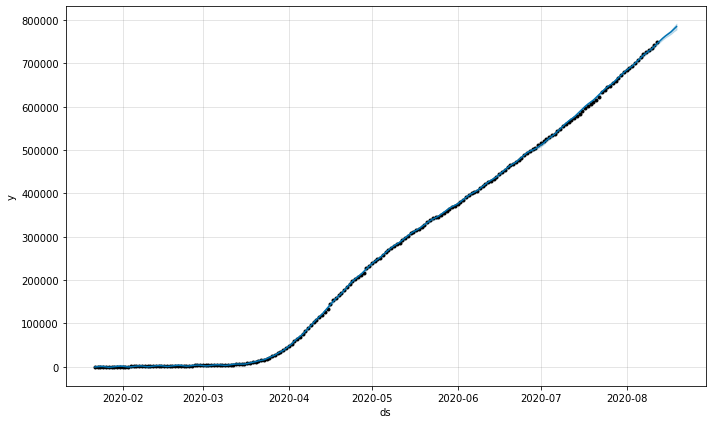

In [ ]:
t=time()
deaths_fore_plot = model.plot(fore_deaths_cases)
print("The processing Time is: ", time()- t,"seconds")

The processing Time is:  0.13291668891906738 seconds


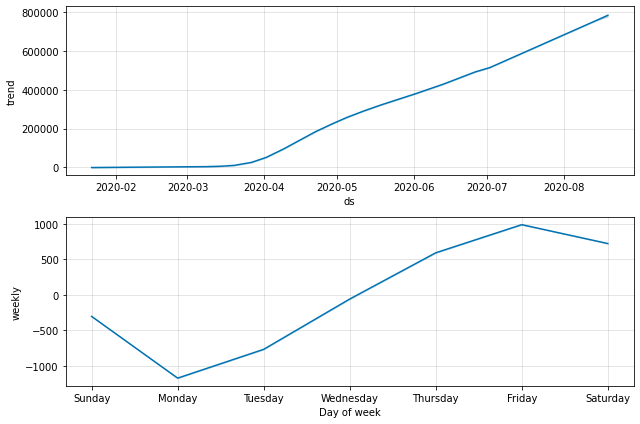

In [ ]:
t=time()
deaths_fore_plot =model.plot_components(fore_deaths_cases)
print("The processing Time is: ", time()- t,"seconds")